In [1]:
import os
import torch
import mlflow
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Enable MLflow autologging 
mlflow.pytorch.autolog()

2025/02/19 06:33:27 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.5.1, but the installed version is 2.6.0+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


In [3]:
# Load the cleaned datasets (from Task 1)
fraud_data = pd.read_csv('../merged_data.csv')
creditcard_data = pd.read_csv('../Preprocessed_Creditcard_Data.csv')

# Drop unnecessary columns for training
fraud_data = fraud_data.drop(columns=['signup_time', 'purchase_time', 'user_id', 'device_id', 
                                      'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address'], errors='ignore')

print('the merged fraud data')
display(fraud_data.head())

print('credit data')

display(creditcard_data.head())

the merged fraud data


,purchase_value,sex,age,class,time_diff,transaction_count,hour_of_day,day_of_week,purchase_value_scaled,source_Direct,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,47,0,30,0,1008.948611,1,3,6,0.549607,False,...,False,False,False,False,False,False,False,False,False,False
1,15,0,34,0,342.121389,1,20,2,-1.197335,False,...,False,False,False,False,False,False,False,False,False,False
2,44,1,29,0,554.870556,1,23,5,0.385831,False,...,False,False,False,False,False,False,False,False,False,False
3,55,0,30,0,2122.471389,1,16,5,0.986342,True,...,False,False,False,False,False,False,False,False,False,False
4,51,0,37,0,2847.105278,1,4,1,0.767974,False,...,False,False,False,False,False,False,False,False,False,False


credit data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,time_in_days,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,0.244200
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,-0.342584
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000012,1.158900
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000012,0.139886
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000023,-0.073813


In [4]:
# Separate features and targets for Fraud Data
X_fraud = fraud_data.drop(columns=['class'])  # Feature set
y_fraud = fraud_data['class']  # Target

# Separate features and targets for Credit Card Data
X_credit = creditcard_data.drop(columns=['Class'])  # Feature set
y_credit = creditcard_data['Class']  # Target

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_fraud, y_fraud = smote.fit_resample(X_fraud, y_fraud)
X_credit, y_credit = smote.fit_resample(X_credit, y_credit)

# Train-Test Split for both datasets
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

# Normalize the data (Standard Scaling)
scaler = StandardScaler()
X_fraud_train = scaler.fit_transform(X_fraud_train)
X_fraud_test = scaler.transform(X_fraud_test)
X_credit_train = scaler.fit_transform(X_credit_train)
X_credit_test = scaler.transform(X_credit_test)

# Convert the datasets into PyTorch tensors
X_fraud_train_tensor = torch.tensor(X_fraud_train, dtype=torch.float32)
y_fraud_train_tensor = torch.tensor(y_fraud_train.values, dtype=torch.float32)
X_fraud_test_tensor = torch.tensor(X_fraud_test, dtype=torch.float32)
y_fraud_test_tensor = torch.tensor(y_fraud_test.values, dtype=torch.float32)

X_credit_train_tensor = torch.tensor(X_credit_train, dtype=torch.float32)
y_credit_train_tensor = torch.tensor(y_credit_train.values, dtype=torch.float32)
X_credit_test_tensor = torch.tensor(X_credit_test, dtype=torch.float32)
y_credit_test_tensor = torch.tensor(y_credit_test.values, dtype=torch.float32)

# DataLoader for batching
batch_size = 16
train_loader_fraud = torch.utils.data.DataLoader(TensorDataset(X_fraud_train_tensor, y_fraud_train_tensor), batch_size=batch_size, shuffle=True)
test_loader_fraud = torch.utils.data.DataLoader(TensorDataset(X_fraud_test_tensor, y_fraud_test_tensor), batch_size=batch_size)

train_loader_credit = torch.utils.data.DataLoader(TensorDataset(X_credit_train_tensor, y_credit_train_tensor), batch_size=batch_size, shuffle=True)
test_loader_credit = torch.utils.data.DataLoader(TensorDataset(X_credit_test_tensor, y_credit_test_tensor), batch_size=batch_size)


In [5]:
# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0


In [6]:
# Model definitions (MLP, CNN, RNN, LSTM)
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.sigmoid(self.fc1(x))
        return x

class RNNModel(nn.Module):
    def __init__(self, input_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        h0 = torch.zeros(1, x.size(0), 32)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = torch.sigmoid(self.fc(out[:, -1, :]))
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        h0 = torch.zeros(1, x.size(0), 32)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), 32)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))
        out = torch.sigmoid(self.fc(out[:, -1, :]))
        return out

In [7]:
# Training loop with MLflow tracking
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, patience=5, model_name="model"):
    early_stopper = EarlyStopping(patience=patience)
    model.train()
    
    with mlflow.start_run(run_name=model_name):
        for epoch in range(num_epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()  # Clear gradients
                y_pred = model(X_batch).squeeze()  # Forward pass
                loss = criterion(y_pred, y_batch)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
            
            # Log loss for each epoch
            mlflow.log_metric('loss', avg_loss, step=epoch)

            # Early stopping
            early_stopper(avg_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

In [8]:
# Model evaluation
# Updated PyTorch model evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).squeeze()
            preds = (y_pred > 0.5).float()  # Convert probabilities to 0/1
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Accuracy: {accuracy:.4f}')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [9]:
# Initialize models for both fraud and credit datasets
input_size_fraud = X_fraud_train.shape[1]
input_size_credit = X_credit_train.shape[1]

mlp_model_fraud = MLPModel(input_size_fraud)
cnn_model_fraud = CNNModel(input_size_fraud)
rnn_model_fraud = RNNModel(input_size_fraud)
lstm_model_fraud = LSTMModel(input_size_fraud)

mlp_model_credit = MLPModel(input_size_credit)
cnn_model_credit = CNNModel(input_size_credit)
rnn_model_credit = RNNModel(input_size_credit)
lstm_model_credit = LSTMModel(input_size_credit)

# Set loss function and optimizer
criterion = nn.BCELoss()

# Train and evaluate each model for both fraud and credit data
models = {
    "MLP_Fraud": mlp_model_fraud,
    "CNN_Fraud": cnn_model_fraud,
    "RNN_Fraud": rnn_model_fraud,
    "LSTM_Fraud": lstm_model_fraud,
    "MLP_Credit": mlp_model_credit,
    "CNN_Credit": cnn_model_credit,
    "RNN_Credit": rnn_model_credit,
    "LSTM_Credit": lstm_model_credit,
}

In [10]:
# saving the models
save_folder = 'DL_saved_models'
os.makedirs(save_folder, exist_ok=True) 

# Function to save PyTorch models
def save_pytorch_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.pt')
    torch.save(model.state_dict(), save_path)
    print(f'{model_name} saved at {save_path}')

In [11]:
# Training and evaluating each model with MLflow tracking
# Modify the existing model loop to include saving logic
for model_name, model in models.items():
    if isinstance(model, nn.Module):  # For PyTorch models
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        print(f"\nTraining {model_name}...")
        train_model(model, train_loader_fraud if "Fraud" in model_name else train_loader_credit, optimizer, criterion)
        print(f"Evaluating {model_name}...")
        evaluate_model(model, test_loader_fraud if "Fraud" in model_name else test_loader_credit)
        save_pytorch_model(model, model_name)  # Save PyTorch model
        print('----------------------------------------------------------------------------------------------------------------------------------------------------')
    else:  
        print("nothing to print")
        


Training MLP_Fraud...
Epoch [1/10], Loss: 0.4066
Epoch [2/10], Loss: 0.3648
Epoch [3/10], Loss: 0.3647
Epoch [4/10], Loss: 0.3580
Epoch [5/10], Loss: 0.3524
Epoch [6/10], Loss: 0.3476
Epoch [7/10], Loss: 0.3459
Epoch [8/10], Loss: 0.3442
Epoch [9/10], Loss: 0.3441
Epoch [10/10], Loss: 0.3460
Evaluating MLP_Fraud...
Accuracy: 0.9328
Precision: 0.9358
Recall: 0.9332
F1 Score: 0.9327
MLP_Fraud saved at DL_saved_models/MLP_Fraud.pt
----------------------------------------------------------------------------------------------------------------------------------------------------

Training CNN_Fraud...
Epoch [1/10], Loss: 0.2650
Epoch [2/10], Loss: 0.1997
Epoch [3/10], Loss: 0.1911
Epoch [4/10], Loss: 0.1875
Epoch [5/10], Loss: 0.1853
Epoch [6/10], Loss: 0.1845
Epoch [7/10], Loss: 0.1834
Epoch [8/10], Loss: 0.1835
Epoch [9/10], Loss: 0.1831
Epoch [10/10], Loss: 0.1816
Evaluating CNN_Fraud...
Accuracy: 0.9408
Precision: 0.9446
Recall: 0.9412
F1 Score: 0.9407
CNN_Fraud saved at DL_saved_model

### Model Explanability using shap

##### Multi-Layer Perceptron (MLP)

Using device: cuda
✅ Model loaded and moved to device.
🔹 Moving test data to GPU...
✅ Test data moved to GPU.
✅ Selected 1000 samples for SHAP.
🔹 Initializing SHAP GradientExplainer...
✅ SHAP Explainer initialized.
🔹 Computing SHAP values in smaller batches...
🔹 Processing batch 1 / 468
🔹 Processing batch 2 / 468
🔹 Processing batch 3 / 468
🔹 Processing batch 4 / 468
🔹 Processing batch 5 / 468
🔹 Processing batch 6 / 468
🔹 Processing batch 7 / 468
🔹 Processing batch 8 / 468
🔹 Processing batch 9 / 468
🔹 Processing batch 10 / 468
🔹 Processing batch 11 / 468
🔹 Processing batch 12 / 468
🔹 Processing batch 13 / 468
🔹 Processing batch 14 / 468
🔹 Processing batch 15 / 468
🔹 Processing batch 16 / 468
🔹 Processing batch 17 / 468
🔹 Processing batch 18 / 468
🔹 Processing batch 19 / 468
🔹 Processing batch 20 / 468
🔹 Processing batch 21 / 468
🔹 Processing batch 22 / 468
🔹 Processing batch 23 / 468
🔹 Processing batch 24 / 468
🔹 Processing batch 25 / 468
🔹 Processing batch 26 / 468
🔹 Processing batch 2

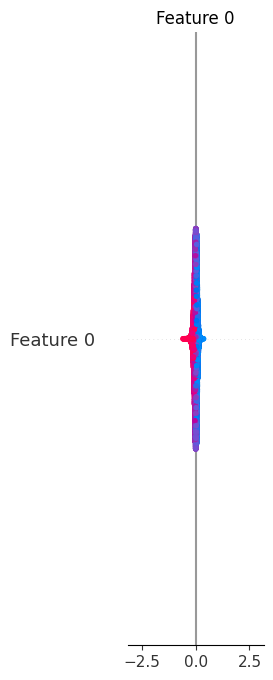

✅ SHAP summary plot displayed.


In [19]:
import shap
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model and move it to GPU
model = mlp_model_fraud.to(device)
model.load_state_dict(torch.load('DL_saved_models/MLP_Fraud.pt', map_location=device))
model.eval()
print("Model loaded and moved to device.")

# Define an optimized SHAP prediction function
def model_predict(input_numpy):
    print("🔹 Running model prediction...")
    input_tensor = torch.as_tensor(input_numpy, dtype=torch.float32, device=device)
    with torch.no_grad():
        output = model(input_tensor)  # Run model on GPU
    print("Prediction complete.")
    return output.cpu().numpy()  # Move result back to CPU for SHAP

# Move test data to GPU efficiently
print("🔹 Moving test data to GPU...")
X_fraud_test_tensor = X_fraud_test_tensor.to(device, non_blocking=True)
print("Test data moved to GPU.")

# Select a subset of test data for SHAP (already on GPU)
X_fraud_test_sample = X_fraud_test_tensor[:1000]  
print(f"Selected {X_fraud_test_sample.shape[0]} samples for SHAP.")

# 🔹 Use GradientExplainer instead of DeepExplainer
print("🔹 Initializing SHAP GradientExplainer...")
explainer = shap.GradientExplainer(model, X_fraud_test_sample)
print("SHAP Explainer initialized.")

# Compute SHAP values in smaller batches
print("🔹 Computing SHAP values in smaller batches...")

try:
    batch_size = 100  # Reduce batch size to avoid memory issues
    shap_values_list = []
    
    for i in range(0, X_fraud_test_tensor.shape[0], batch_size):
        batch = X_fraud_test_tensor[i:i+batch_size]  # Get batch
        print(f"🔹 Processing batch {i // batch_size + 1} / {X_fraud_test_tensor.shape[0] // batch_size + 1}")
        batch_shap_values = explainer.shap_values(batch)  # Compute SHAP values
        shap_values_list.append(batch_shap_values)
    
    # Combine batches back into one array
    shap_values = torch.cat([torch.tensor(sv) for sv in shap_values_list], dim=0).cpu().numpy()
    print("SHAP values computed successfully.")

except Exception as e:
    print(f"Error computing SHAP values: {e}")

# Visualize SHAP values (moving back to CPU for visualization)
print("🔹 Generating SHAP summary plot...")
try:
    shap.summary_plot(shap_values, X_fraud_test_tensor.cpu().numpy())
    print("SHAP summary plot displayed.")
except Exception as e:
    print(f"Error generating SHAP plot: {e}")


CNN

Using device: cuda
Model loaded and moved to device.
Moving test data to GPU...
Test data moved to GPU.
Selected 1000 samples for SHAP.
🔹 Initializing SHAP GradientExplainer...
SHAP Explainer initialized.
🔹 Computing SHAP values in smaller batches...
🔹 Processing batch 1 / 468
🔹 Processing batch 2 / 468
🔹 Processing batch 3 / 468
🔹 Processing batch 4 / 468
🔹 Processing batch 5 / 468
🔹 Processing batch 6 / 468
🔹 Processing batch 7 / 468
🔹 Processing batch 8 / 468
🔹 Processing batch 9 / 468
🔹 Processing batch 10 / 468
🔹 Processing batch 11 / 468
🔹 Processing batch 12 / 468
🔹 Processing batch 13 / 468
🔹 Processing batch 14 / 468
🔹 Processing batch 15 / 468
🔹 Processing batch 16 / 468
🔹 Processing batch 17 / 468
🔹 Processing batch 18 / 468
🔹 Processing batch 19 / 468
🔹 Processing batch 20 / 468
🔹 Processing batch 21 / 468
🔹 Processing batch 22 / 468
🔹 Processing batch 23 / 468
🔹 Processing batch 24 / 468
🔹 Processing batch 25 / 468
🔹 Processing batch 26 / 468
🔹 Processing batch 27 / 468
🔹 

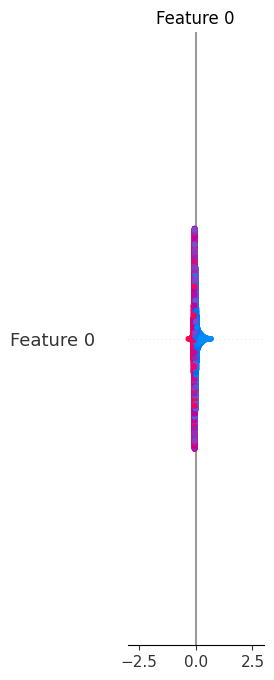

 SHAP summary plot displayed.


In [20]:
import shap
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model and move it to GPU
model = cnn_model_fraud.to(device)
model.load_state_dict(torch.load('DL_saved_models/CNN_Fraud.pt', map_location=device))
model.eval()
print("Model loaded and moved to device.")

# Define an optimized SHAP prediction function
def model_predict(input_numpy):
    input_tensor = torch.as_tensor(input_numpy, dtype=torch.float32, device=device)  # Efficient conversion
    with torch.no_grad():
        output = model(input_tensor)  # Run model on GPU
    return output.cpu().numpy()  # Move result back to CPU for SHAP

# Move test data to GPU efficiently
print("Moving test data to GPU...")
X_fraud_test_tensor = X_fraud_test_tensor.to(device, non_blocking=True)
print("Test data moved to GPU.")

# Select a subset of test data for SHAP (already on GPU)
X_fraud_test_sample = X_fraud_test_tensor[:1000]  
print(f"Selected {X_fraud_test_sample.shape[0]} samples for SHAP.")

# Use GradientExplainer instead of KernelExplainer (much faster)
print("🔹 Initializing SHAP GradientExplainer...")
explainer = shap.GradientExplainer(model, X_fraud_test_sample)
print("SHAP Explainer initialized.")

# Compute SHAP values in smaller batches
print("🔹 Computing SHAP values in smaller batches...")

try:
    batch_size = 100  # Reduce batch size to avoid memory issues
    shap_values_list = []
    
    for i in range(0, X_fraud_test_tensor.shape[0], batch_size):
        batch = X_fraud_test_tensor[i:i+batch_size]  # Get batch
        print(f"🔹 Processing batch {i // batch_size + 1} / {X_fraud_test_tensor.shape[0] // batch_size + 1}")
        batch_shap_values = explainer.shap_values(batch)  # Compute SHAP values
        shap_values_list.append(batch_shap_values)
    
    # Combine batches back into one array
    shap_values = torch.cat([torch.tensor(sv) for sv in shap_values_list], dim=0).cpu().numpy()
    print(" SHAP values computed successfully.")

except Exception as e:
    print(f" Error computing SHAP values: {e}")

# Visualize SHAP values (moving back to CPU for visualization)
print("🔹 Generating SHAP summary plot...")
try:
    shap.summary_plot(shap_values, X_fraud_test_tensor.cpu().numpy())
    print(" SHAP summary plot displayed.")
except Exception as e:
    print(f" Error generating SHAP plot: {e}")


##### Recurrent Neural Network

  0%|          | 0/46752 [00:00<?, ?it/s]

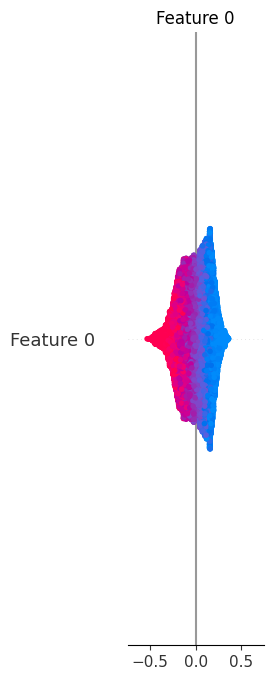

In [50]:
# Load the model
model = rnn_model_fraud
model.load_state_dict(torch.load('DL_saved_models/RNN_Fraud.pt'))

# Move the model to CPU (ensure the model's parameters are on CPU)
model = model.cpu()

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    input_tensor = input_tensor.cpu()  # Move input to CPU to match model device
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(input_tensor)
    return output.detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array (moving data to CPU)
X_fraud_test_numpy = X_fraud_test_tensor.cpu().numpy()

# Select a subset of your test data for SHAP (working with smaller subset for faster computation)
X_fraud_test_sample = X_fraud_test_numpy[:10]  # Adjust the number of samples based on memory limitations

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)


LTSM

  0%|          | 0/46752 [00:00<?, ?it/s]

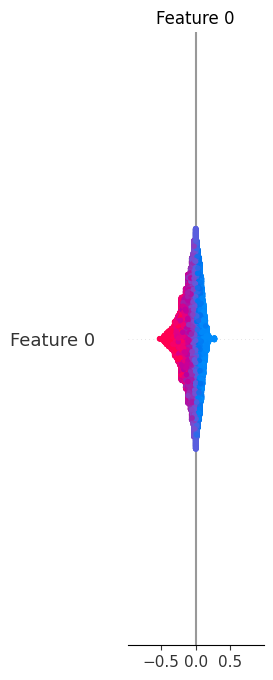

In [61]:
model = lstm_model_fraud 
# Load the saved model weights from the .pt file
model.load_state_dict(torch.load('DL_saved_models/LSTM_Fraud.pt'))

## Move the model to CPU (ensure the model's parameters are on CPU)
model = model.cpu()

# Set the model to evaluation mode
model.eval()

# Define a custom prediction function for SHAP
def model_predict(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32)  # Convert back to tensor
    input_tensor = input_tensor.cpu()  # Move input to CPU to match model device
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(input_tensor)
    return output.detach().cpu().numpy()  # Return numpy predictions

# Convert test tensor to numpy array (moving data to CPU)
X_fraud_test_numpy = X_fraud_test_tensor.cpu().numpy()

# Select a subset of your test data for SHAP (working with smaller subset for faster computation)
X_fraud_test_sample = X_fraud_test_numpy[:1]  # Adjust the number of samples based on memory limitations

# Use KernelExplainer for SHAP values
explainer = shap.KernelExplainer(model_predict, X_fraud_test_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_fraud_test_numpy)

# Visualize SHAP values
shap.summary_plot(shap_values, X_fraud_test_numpy)
